Using device: mps
 Fine-tuning on Chatbot Data


/Users/ethan/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



[Chatbot] Epoch 1/3


Training Loss: 0.1418


Validation Loss: 0.0103 | Acc: 0.9962 | Prec: 1.0000 | Rec: 0.9920 | F1: 0.9960

[Chatbot] Epoch 2/3


Training Loss: 0.0041


Validation Loss: 0.0071 | Acc: 0.9987 | Prec: 1.0000 | Rec: 0.9973 | F1: 0.9987

[Chatbot] Epoch 3/3


Training Loss: 0.0025


Validation Loss: 0.0076 | Acc: 0.9975 | Prec: 1.0000 | Rec: 0.9947 | F1: 0.9973

 Fine-tuning on Social Media Data


/Users/ethan/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



[Social] Epoch 1/3


Training Loss: 0.3793


Validation Loss: 0.3029 | Acc: 0.8690 | Prec: 0.8886 | Rec: 0.8460 | F1: 0.8668

[Social] Epoch 2/3


Training Loss: 0.2015


Validation Loss: 0.3290 | Acc: 0.8728 | Prec: 0.8645 | Rec: 0.8864 | F1: 0.8753

[Social] Epoch 3/3


Training Loss: 0.1098


Validation Loss: 0.3645 | Acc: 0.8779 | Prec: 0.8750 | Rec: 0.8838 | F1: 0.8794

 Aggregating the Models
Model aggregation complete.

 Evaluating Aggregated Model

-- Test on Chatbot Test Set --


Test (Chatbot) Loss: 0.1738
Test (Chatbot) Accuracy: 0.9389
Test (Chatbot) Precision: 0.9553
Test (Chatbot) Recall: 0.9144
Test (Chatbot) F1 Score: 0.9344


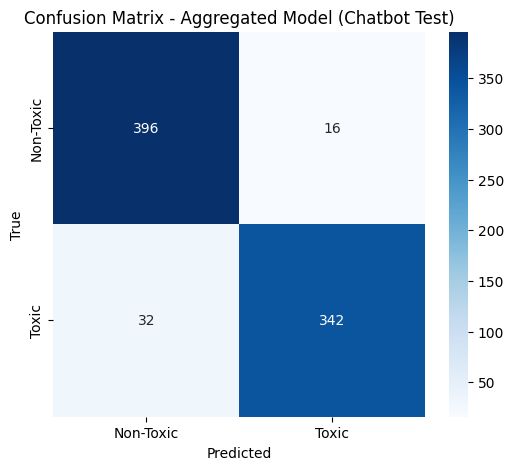


-- Test on Social Media Test Set --


Test (Social Media) Loss: 0.9206
Test (Social Media) Accuracy: 0.7226
Test (Social Media) Precision: 0.6488
Test (Social Media) Recall: 0.9798
Test (Social Media) F1 Score: 0.7807


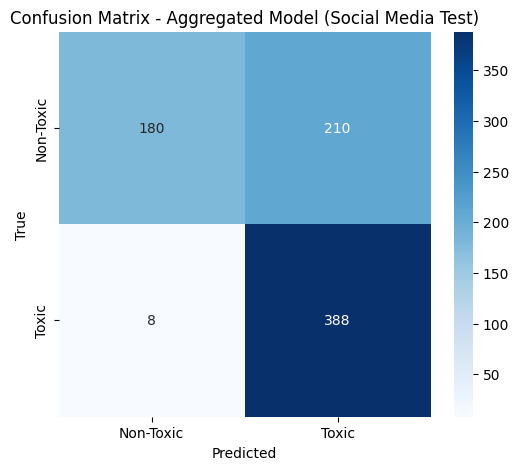


 Start to save the model.

Model All saved.

All steps completed.


In [1]:
import torch
from transformers import AdamW, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
# Global Setup
# -----------------------------------------------------------------------------

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use the new tokenizer from the JungleLee repository
tokenizer = AutoTokenizer.from_pretrained("JungleLee/bert-toxic-comment-classification")

# Select device: prefer MPS, then CUDA, then CPU
device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
print("Using device:", device)

# -----------------------------------------------------------------------------
# Helper Classes & Functions
# -----------------------------------------------------------------------------

class TextDataset(Dataset):
    """
    Torch Dataset for text classification data.
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def load_data(file_path):
    """
    Loads and preprocesses data from a CSV file with columns 'cleaned_text' and 'label'.
    """
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['cleaned_text', 'label'])  # Remove rows with missing values
    data['cleaned_text'] = data['cleaned_text'].astype(str)
    return data["cleaned_text"].tolist(), data["label"].tolist()

def create_dataloader(texts, labels, tokenizer, batch_size=8, shuffle=False):
    dataset = TextDataset(texts, labels, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def get_model():
    """
    Loads the model from the JungleLee repository.
    """
    return AutoModelForSequenceClassification.from_pretrained("JungleLee/bert-toxic-comment-classification")

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    """
    Trains the model for one epoch.
    """
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix(loss=loss.item())
    
    return epoch_loss / len(dataloader)

def validate(model, dataloader, device):
    """
    Validates the model.
    """
    model.eval()
    val_losses = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_losses.append(loss.item())
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    average_loss = np.mean(val_losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return average_loss, accuracy, precision, recall, f1, all_labels, all_preds

def evaluate(model, dataloader, device):
    """
    Evaluates the model on the test set.
    """
    model.eval()
    test_losses = []
    test_labels_list = []
    test_preds_list = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Testing", leave=False)
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_losses.append(loss.item())
            
            preds = torch.argmax(outputs.logits, dim=1)
            test_labels_list.extend(labels.cpu().numpy())
            test_preds_list.extend(preds.cpu().numpy())
    
    average_test_loss = np.mean(test_losses)
    test_accuracy = accuracy_score(test_labels_list, test_preds_list)
    test_precision = precision_score(test_labels_list, test_preds_list, zero_division=0)
    test_recall = recall_score(test_labels_list, test_preds_list, zero_division=0)
    test_f1 = f1_score(test_labels_list, test_preds_list, zero_division=0)
    
    return average_test_loss, test_accuracy, test_precision, test_recall, test_f1, test_labels_list, test_preds_list

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def aggregate_models(model1, model2):
    """
    Aggregates two models by combining their parameters elementwise such that if at least one model 
    leans "toxic" (represented by a positive parameter value), then the aggregated parameter is positive.
    Specifically:
      - Each parameter's sign is computed as +1 if > 0 (toxic) or -1 if ≤ 0 (non-toxic).
      - The aggregated sign is the maximum of the two signs, so that if either is +1, the result is +1.
      - The magnitude is computed as the average of the absolute values.
    """
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    aggregated_state_dict = {}

    for key in state_dict1.keys():
        param1 = state_dict1[key]
        param2 = state_dict2[key]
        
        # Determine sign: +1 if parameter > 0 (toxic), -1 otherwise (non-toxic)
        s1 = (param1 > 0).float() * 2 - 1
        s2 = (param2 > 0).float() * 2 - 1
        
        # Aggregated sign: if either s1 or s2 is +1, then the aggregated sign is +1; otherwise, it's -1.
        aggregated_sign = torch.max(s1, s2)
        
        # Average magnitude of the parameters
        magnitude = 0.5 * (torch.abs(param1) + torch.abs(param2))
        
        # Aggregated parameter is the sign times the averaged magnitude.
        aggregated_state_dict[key] = aggregated_sign * magnitude

    # Use get_model() here instead of get_peft_model() to create a new model instance.
    aggregated_model = get_model().to(device)
    aggregated_model.load_state_dict(aggregated_state_dict)
    return aggregated_model


# Define class names for confusion matrices
class_names = ['Non-Toxic', 'Toxic']

# -----------------------------------------------------------------------------
# Experiment: Fine-tuning on Chatbot Data
# -----------------------------------------------------------------------------
print("=======================================")
print(" Fine-tuning on Chatbot Data")
print("=======================================")

# Load Chatbot data
chatbot_train_texts, chatbot_train_labels = load_data("chatbot_final_data_train.csv")
chatbot_val_texts,   chatbot_val_labels   = load_data("chatbot_final_data_test.csv")
chatbot_test_texts,  chatbot_test_labels  = load_data("chatbot_final_data_test.csv")

# Create dataloaders for Chatbot data
train_dataloader_chatbot = create_dataloader(chatbot_train_texts, chatbot_train_labels, tokenizer, batch_size=8, shuffle=True)
val_dataloader_chatbot   = create_dataloader(chatbot_val_texts,   chatbot_val_labels,   tokenizer, batch_size=8, shuffle=False)
test_dataloader_chatbot  = create_dataloader(chatbot_test_texts,  chatbot_test_labels,  tokenizer, batch_size=8, shuffle=False)

# Initialize and train model on Chatbot data
model_chatbot = get_model().to(device)
optimizer_chatbot = AdamW(model_chatbot.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader_chatbot)
lr_scheduler_chatbot = get_scheduler("linear", optimizer=optimizer_chatbot, num_warmup_steps=0, num_training_steps=num_training_steps)

for epoch in range(num_epochs):
    print(f"\n[Chatbot] Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model_chatbot, train_dataloader_chatbot, optimizer_chatbot, lr_scheduler_chatbot, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = validate(model_chatbot, val_dataloader_chatbot, device)
    print(f"Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

# -----------------------------------------------------------------------------
# Experiment: Fine-tuning on Social Media Data
# -----------------------------------------------------------------------------
print("\n=======================================")
print(" Fine-tuning on Social Media Data")
print("=======================================")

# Load Social Media data
social_train_texts, social_train_labels = load_data("social_media_final_data_train.csv")
social_val_texts,   social_val_labels   = load_data("social_media_final_data_test.csv")
social_test_texts,  social_test_labels  = load_data("social_media_final_data_test.csv")

# Create dataloaders for Social Media data
train_dataloader_social = create_dataloader(social_train_texts, social_train_labels, tokenizer, batch_size=8, shuffle=True)
val_dataloader_social   = create_dataloader(social_val_texts,   social_val_labels,   tokenizer, batch_size=8, shuffle=False)
test_dataloader_social  = create_dataloader(social_test_texts,  social_test_labels,  tokenizer, batch_size=8, shuffle=False)

# Initialize and train model on Social Media data
model_social = get_model().to(device)
optimizer_social = AdamW(model_social.parameters(), lr=2e-5)
num_training_steps_social = num_epochs * len(train_dataloader_social)
lr_scheduler_social = get_scheduler("linear", optimizer=optimizer_social, num_warmup_steps=0, num_training_steps=num_training_steps_social)

for epoch in range(num_epochs):
    print(f"\n[Social] Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model_social, train_dataloader_social, optimizer_social, lr_scheduler_social, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = validate(model_social, val_dataloader_social, device)
    print(f"Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

# -----------------------------------------------------------------------------
# Aggregate the Two Fine-Tuned Models
# -----------------------------------------------------------------------------
print("\n=======================================")
print(" Aggregating the Models")
print("=======================================")

aggregated_model = aggregate_models(model_chatbot, model_social)
print("Model aggregation complete.")

# -----------------------------------------------------------------------------
# Evaluate the Aggregated Model on Test Sets
# -----------------------------------------------------------------------------
print("\n=======================================")
print(" Evaluating Aggregated Model")
print("=======================================")

# Evaluate on Chatbot Test Set
print("\n-- Test on Chatbot Test Set --")
test_loss_cb, test_acc_cb, test_prec_cb, test_rec_cb, test_f1_cb, y_true_cb, y_pred_cb = evaluate(aggregated_model, test_dataloader_chatbot, device)
print(f"Test (Chatbot) Loss: {test_loss_cb:.4f}")
print(f"Test (Chatbot) Accuracy: {test_acc_cb:.4f}")
print(f"Test (Chatbot) Precision: {test_prec_cb:.4f}")
print(f"Test (Chatbot) Recall: {test_rec_cb:.4f}")
print(f"Test (Chatbot) F1 Score: {test_f1_cb:.4f}")
plot_confusion_matrix(y_true_cb, y_pred_cb, classes=class_names, title="Confusion Matrix - Aggregated Model (Chatbot Test)")

# Evaluate on Social Media Test Set
print("\n-- Test on Social Media Test Set --")
test_loss_sm, test_acc_sm, test_prec_sm, test_rec_sm, test_f1_sm, y_true_sm, y_pred_sm = evaluate(aggregated_model, test_dataloader_social, device)
print(f"Test (Social Media) Loss: {test_loss_sm:.4f}")
print(f"Test (Social Media) Accuracy: {test_acc_sm:.4f}")
print(f"Test (Social Media) Precision: {test_prec_sm:.4f}")
print(f"Test (Social Media) Recall: {test_rec_sm:.4f}")
print(f"Test (Social Media) F1 Score: {test_f1_sm:.4f}")
plot_confusion_matrix(y_true_sm, y_pred_sm, classes=class_names, title="Confusion Matrix - Aggregated Model (Social Media Test)")

print("\n Start to save the model.")

# Save the fine-tuned Chatbot model (e.g., for finance-related tasks)
model_chatbot.save_pretrained("bert_finance")

# Save the fine-tuned Social Media model
model_social.save_pretrained("bert_soical")

print("\nModel All saved.")

print("\nAll steps completed.")
